# Setup

In [1]:
import ast
import itertools
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans

In [2]:
!ls archive

PP_recipes.csv              ingr_map.pkl
PP_users.csv                interactions_test.csv
RAW_interactions.csv        interactions_train.csv
RAW_recipes.csv             interactions_validation.csv


In [3]:
data_path = 'archive'

# Loading data
recipe_df = pd.read_csv(f'{data_path}/RAW_recipes.csv')
interactions_df = pd.read_csv(f'{data_path}/RAW_interactions.csv')

# Loading ingredient map
with open(f'{data_path}/ingr_map.pkl', 'rb') as pfile:
    ingredient_map = pickle.load(pfile)

In [3]:
recipe_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [4]:
interactions_df.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [5]:
ingredient_map.head()

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
0,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507,4308
1,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507,4308
2,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507,4308
3,iceberg lettuce leaf,3,iceberg lettuce leaf,20,lettuce,4507,4308
4,red romaine lettuce,3,red romaine lettuce,19,lettuce,4507,4308


In [ ]:
ingredient_map.shape

(11659, 7)

In [ ]:
# Different ingredients after processing
ingredient_map.replaced.value_counts()

dressing                163
sausage                 154
chile                    99
cake mix                 85
cheddar                  84
                       ... 
sliced olife              1
spicy tomato salsa        1
mexican blend cheese      1
ham soup base             1
khoya                     1
Name: replaced, Length: 8023, dtype: int64

There are quite a few ingredients mapped to some vague categories, so we should see how broad these become

In [ ]:
ingredient_map[ingredient_map.replaced == 'dressing'].head()

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
373,hidden valley original ranch dressing and seas...,8,ranch dressing and seasoning mix,32,dressing,3694,2200
374,hidden valley original ranch cheddar and parme...,8,ranch cheddar and parmesan dressing,35,dressing,3694,2200
375,kraft roasted red pepper italian parmesan dres...,7,roasted red pepper italian parmesan dressing,44,dressing,3694,2200
376,greek vinaigrette dressing with feta and oregano,7,greek vinaigrette dressing,26,dressing,3694,2200
377,kraft tuscan house italian dressing and marinade,7,house italian dressing and marinade,35,dressing,3694,2200


In [ ]:
ingredient_map[ingredient_map.replaced == 'sausage'].head()

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
1163,johnsonville hot & spicy breakfast sausage,6,hot & spicy breakfast sausage,29,sausage,4507,6324
1164,johnsonville hot italian sausage links,5,hot italian sausage link,24,sausage,4507,6324
1165,sweet italian turkey sausage links,5,sweet italian turkey sausage link,33,sausage,4507,6324
1166,lightlife gimme lean ground sausage,5,ground sausage,14,sausage,4507,6324
1167,johnsonville mild italian sausage links,5,mild italian sausage link,25,sausage,4507,6324


It looks like these aren't all necessarily perfect substitutes for each other, so we may not want to use the processed ingredients for finding "similar" recipes. For instance, someone making a dish that they really enjoy with breakfast sausage won't necessarily want a dish that calls for sausage links. Maybe we can have a distinction to allow users to say they want to match exact ingredients vs "similar" (processed) ingredients.

# Feature Transformation

Since the data are from a CSV, our list attributes are all transformed into strings. In order to use them, we need to transform them back into lists.

In [4]:
for col_to_trsfm in ['tags', 'nutrition', 'steps', 'ingredients']:
    # Make sure that we aren't reapplying to already-transformed columns
    try:
        recipe_df[col_to_trsfm] = recipe_df[col_to_trsfm].apply(
            ast.literal_eval
        )
    except ValueError as e:
        # If a different ValueError is encountered, don't want to let it pass
        if 'malformed node or string' not in str(e):
            raise e

## Transform ingredients to Binary Representation

In [9]:
recipe_df['ingredients']

0         [winter squash, mexican seasoning, mixed spice...
1         [prepared pizza crust, sausage patty, eggs, mi...
2         [ground beef, yellow onions, diced tomatoes, t...
3         [spreadable cheese with garlic and herbs, new ...
4         [tomato juice, apple cider vinegar, sugar, sal...
                                ...                        
231632    [celery, onion, green sweet pepper, garlic clo...
231633    [paprika, salt, garlic powder, onion powder, d...
231634    [hard-cooked eggs, mayonnaise, dijon mustard, ...
231635    [butter, eagle brand condensed milk, light bro...
231636    [granulated sugar, shortening, eggs, flour, cr...
Name: ingredients, Length: 231637, dtype: object

In [5]:
ingredients_list = itertools.chain.from_iterable(recipe_df.ingredients)
ingredients = [list(set(ingredients_list))]

In [6]:
ingredients

[['salted macadamia nuts',
  'instant coffee powder',
  'chipotle peppers',
  'green tomato relish',
  'corn cobs',
  'mussels',
  'granulated brown sugar',
  'prego extra chunky mushroom & diced tomato spaghetti sauce',
  'raspberry ice cream',
  'honey-roasted pecans',
  'truffles',
  'fruit-flavored cream cheese',
  'gluten-free cereal',
  'soft egg sandwich buns',
  'vegetarian banana pudding mix',
  'raspberry vinaigrette dressing',
  'whole canned tomatoes',
  'light chocolate yogurt',
  'muscovado sugar',
  'silken tofu',
  'roast pork',
  'sun-dried tomato flat bread',
  'honey glaze mix',
  'orange-pineapple flavored gelatin',
  'tofutti sour supreme natural flavor',
  'light vanilla soymilk',
  'nacho cheese flavored tortilla chips',
  'smuckers baking healthy oil & shortening',
  'whole meal flour',
  'strawberry jelly crystals',
  'maca',
  'pastry for 9" pie',
  'fat free banana cream pie flavored pudding mix',
  'salsa con queso',
  '9" pastry pie shells',
  'lavender oil

In [7]:
ingredient_encoder = MultiLabelBinarizer().fit(ingredients)

In [8]:
ingredient_encoder.classes_.shape

(14942,)

In [14]:
encoded_df.ingredients[0]

['winter squash',
 'mexican seasoning',
 'mixed spice',
 'honey',
 'butter',
 'olive oil',
 'salt']

In [28]:
binarized_ingredients = ingredient_encoder.transform(recipe_df.ingredients)

In [39]:
np.save('FULL_binarized_ingredients.npy', binarized_ingredients)

In [40]:
np.save('FULL_binarized_ingredient_labels.npy', ingredient_encoder.classes_)

## Add average user rating to recipes

In [5]:
rating_counts = interactions_df['recipe_id'].value_counts().to_frame().rename(columns={'recipe_id': 'num_ratings'})

In [6]:
average_ratings = interactions_df.groupby('recipe_id')['rating'].mean().to_frame().rename(columns={'rating': 'average_rating'})

In [7]:
# Add average_ratings
recipe_df = pd.merge(recipe_df, average_ratings, left_on='id', right_index=True)

# Add num_ratings (so we have some confidence measure)
recipe_df = pd.merge(recipe_df, rating_counts, left_on='id', right_index=True)

In [8]:
recipe_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,average_rating,num_ratings
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7,5.0,3
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6,3.5,4
2,all in the kitchen chili,112140,130,196586,2005-02-25,"[time-to-make, course, preparation, main-dish,...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"[brown ground beef in large pot, add chopped o...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13,4.0,1
3,alouette potatoes,59389,45,68585,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,[place potatoes in a large pot of lightly salt...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11,4.5,2
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"[weeknight, time-to-make, course, main-ingredi...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"[mix all ingredients& boil for 2 1 / 2 hours ,...",my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8,5.0,1


# Exploration

## Check data sanitation

In [ ]:
recipe_df[recipe_df.isna().any(axis=1)].apply(lambda x: sum([pd.isna(v) for v in x]))

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64

So we have one recipe missing a name, and 4979 missing a description.

In [ ]:
recipe_df.describe()

,id,minutes,contributor_id,n_steps,n_ingredients
count,231637.000000,2.316370e+05,2.316370e+05,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,9.765499,9.051153
std,141206.635626,4.461963e+06,9.979141e+07,5.995128,3.734796
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000
25%,99944.000000,2.000000e+01,5.690500e+04,6.000000,6.000000
50%,207249.000000,4.000000e+01,1.736140e+05,9.000000,9.000000
75%,333816.000000,6.500000e+01,3.982750e+05,12.000000,11.000000
max,537716.000000,2.147484e+09,2.002290e+09,145.000000,43.000000


Based on above, we have some recipes with a very long cook time, so we should inspect them.

In [ ]:
# See what takes over a day to make
recipe_df[recipe_df.minutes > 10000]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
50,keep it going german friendship cake,26995,14450,37305,2002-04-30,"['weeknight', 'time-to-make', 'course', 'main-...","[724.4, 38.0, 297.0, 20.0, 18.0, 31.0, 39.0]",13,['mix starter ingredients in a bowl and let st...,"yes, this sounds bizarre, but it really is tas...","['flour', 'water', 'dry yeast', 'milk', 'sugar...",17
58,marijuana vinegar,24478,20160,32692,2002-04-08,"['weeknight', 'time-to-make', 'course', 'cuisi...","[3.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",5,['mix the herbs and vinegar together in a jar'...,stefan and emily used to make this stuff when ...,"['fresh herbs', 'cider vinegar', 'fresh herb']",3
317,apple pie,124853,43200,213699,2005-06-06,"['time-to-make', 'course', 'main-ingredient', ...","[285.8, 0.0, 281.0, 0.0, 0.0, 0.0, 24.0]",2,['mix ingredence together except everclear and...,a home made alcohalic drink it take 1 month fo...,"['apple juice', 'raw honey', 'whole cloves', '...",6
929,14 day coleslaw,129227,20175,11297,2005-07-11,"['time-to-make', 'course', 'main-ingredient', ...","[1185.8, 5.0, 976.0, 156.0, 33.0, 1.0, 93.0]",7,['boil together all the dressing ingredients u...,another different way to have coleslaw. a lig...,"['white vinegar', 'water', 'sugar', 'celery se...",10
931,14 day unsealed pickles,17490,20160,28533,2002-01-19,"['weeknight', 'time-to-make', 'course', 'prepa...","[13465.2, 5.0, 12914.0, 14152.0, 42.0, 5.0, 10...",17,['1st day: dissolve salt in 1 gallon boiling w...,this is not my recipe. found it on key gourmet...,"['cucumbers', 'canning salt', 'vinegar', 'alum...",6
...,...,...,...,...,...,...,...,...,...,...,...,...
223598,vine torte or prune cake,46390,20280,56970,2002-11-16,"['danish', 'weeknight', 'time-to-make', 'cours...","[7245.4, 310.0, 2594.0, 182.0, 176.0, 188.0, 4...",14,"['mix cookie ingredients as for cookies', 'div...",this was made every year in my household at ch...,"['flour', 'baking powder', 'salt', 'margarine'...",11
227347,wild grape wine,38780,15900,53581,2002-08-28,"['time-to-make', 'course', 'main-ingredient', ...","[2.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",10,"['choose ripe wild grapes , pick them in clust...",this wine is ready to drink and bottle in 11 d...,"['grapes', 'sugar', 'water', 'yeast', 'dried b...",5
228147,word stew,329162,43215,31807,2008-10-06,"['time-to-make', 'course', 'main-ingredient', ...","[309.7, 3.0, 41.0, 1.0, 34.0, 2.0, 19.0]",6,"['warm the olive oil in a large pot', 'add the...",from vivichick's blog at http://vivichick.live...,"['olive oil', 'garlic cloves', 'onion', 'eggpl...",12
228782,ww slow cooker beef stroganoff,179138,11555,32772,2006-07-24,"['time-to-make', 'course', 'main-ingredient', ...","[1518.0, 198.0, 16.0, 17.0, 55.0, 271.0, 20.0]",16,"['wrap steak in heavy duty plastic wrap', 'fre...",only 9 points.,"['beef', 'onion', 'sliced mushrooms', 'dijon m...",13


Based on the above, it tends to be that the long recipes are things you might expect to take a long time, so it's not necessarily alarming. For instance, sourdough bread or 14 day cole slaw are justified to have cook times that might be invalid at first glance.

## Initial visualization

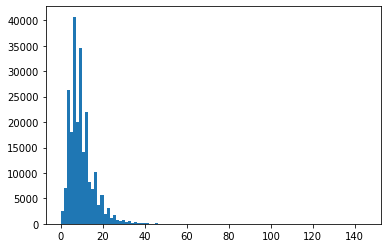

In [ ]:
fig = plt.hist(recipe_df.n_steps, bins=100)

Since we have some outliers for cook time, we split up the histograms based on this

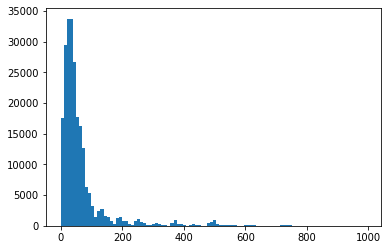

In [ ]:
fig = plt.hist(recipe_df[recipe_df.minutes < 1000].minutes, bins=100)

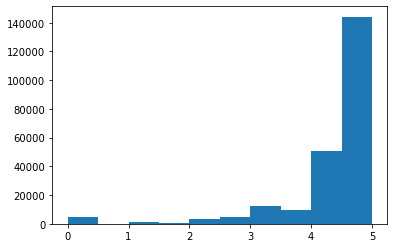

In [48]:
fig = plt.hist(recipe_df.average_rating, bins=10)

So recipes are much higher skewed towards positive reviews. This means that simply recommending based on review will be difficult. Maybe there's a way we can look at positive reviews in the scope of recipes that are already somewhat similar in some other regard (number of steps, type of ingredients, nutritional breakdown, etc.)

Text(0, 0.5, '# of reviews')

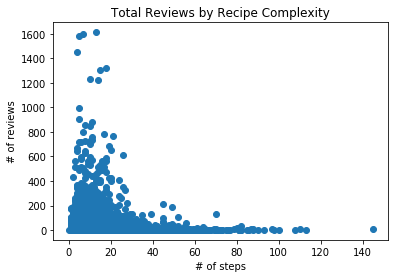

In [19]:
plt.title('Total Reviews by Recipe Complexity')
plt.scatter(recipe_df.n_steps, recipe_df.num_ratings)
plt.xlabel('# of steps')
plt.ylabel('# of reviews')

Perhaps unsurprisingly, we see that the number of reviews drops off very steeply as the number of steps in a recipe increases.  

Text(0, 0.5, '# of reviews')

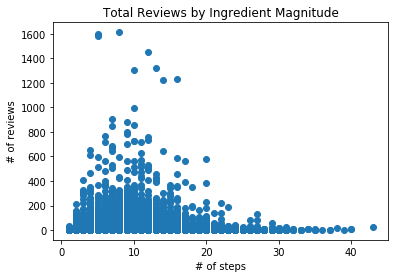

In [24]:
plt.title('Total Reviews by Ingredient Magnitude')
plt.scatter(recipe_df.n_ingredients, recipe_df.num_ratings)
plt.xlabel('# of steps')
plt.ylabel('# of reviews')

It appears that users tend to have a middle-ground in terms of the number of ingredients where they are more likely to review (or perhaps try) a recipe. We can interpret this as users not wanting to buy lots of ingredients for a dish, but are also more likely to want to make something with more than just two or three ingredients in it.